# Convergence and performance

To optimize simulation time vs accuracy, an estimate of the acaling of the algorithm is required. For this purpose, there are two methods provided in the `Cell` and the `Layer` classes.

Below a simple example is set up to quickly run these tests. The structure here is a 300 nm layer of silicon on glass with cylindrical air holes arranged in a square lattice of periodicity 1 μm.

In [1]:
import beams as bm
import numpy as np
from time import time
import matplotlib.pyplot as plt

p = bm.Vector2d(1, 1)

air = bm.Material()
si = bm.Material(index=3.4) 
sio2 = bm.Material(epsilon=1.5 ** 2)

hole = bm.Ellipse(r=.3, material=air) 
phc = bm.Layer(h=.3, material=si, shapes=[hole], resolution=500)

## Linear algebra

The size of the linear algebra problems is determined by the number of modes $N$. The accuracy and performance of `Layer.compute_eigs` and `Cell.linsolve` methods can be obtained using `Cell.convergence`.

#### Parameters
- `N_max`: The maximum number of modes to compute upto. The method will run the simulation for every odd integer from 1 to `N_max`.
- `**kwargs`: The frequency and angles that are passed to the `Cell.R_T()` method.

In [2]:
inc = bm.Layer()
sub = bm.Layer(material=sio2)
cell = bm.Cell(period=p, N=5, layers=[inc, phc, sub])

f = 0.75
a = bm.Vector3d(np.pi / 3, np.pi / 6, np.pi / 2)

N_max = 35
(RT, tt) = cell.convergence(N_max, freq=f, angles=a)

N = (1, 1): R = 0.20595, T = 0.82672
0.072s taken per iteration.
N = (3, 3): R = 0.72762, T = 0.27238
0.071s taken per iteration.
N = (5, 5): R = 0.74656, T = 0.25344
0.097s taken per iteration.
N = (7, 7): R = 0.63095, T = 0.36905
0.155s taken per iteration.
N = (9, 9): R = 0.61906, T = 0.38094
0.305s taken per iteration.
N = (11, 11): R = 0.61294, T = 0.38706
0.585s taken per iteration.
N = (13, 13): R = 0.61003, T = 0.38997
1.078s taken per iteration.
N = (15, 15): R = 0.60809, T = 0.39191
2.135s taken per iteration.
N = (17, 17): R = 0.60675, T = 0.39325
3.376s taken per iteration.
N = (19, 19): R = 0.60581, T = 0.39419
5.434s taken per iteration.
N = (21, 21): R = 0.60507, T = 0.39493
8.949s taken per iteration.
N = (23, 23): R = 0.6045, T = 0.3955
13.525s taken per iteration.
N = (25, 25): R = 0.60406, T = 0.39594
20.187s taken per iteration.
N = (27, 27): R = 0.60368, T = 0.39632
29.978s taken per iteration.
N = (29, 29): R = 0.60339, T = 0.39661
44.798s taken per iteration.
N =

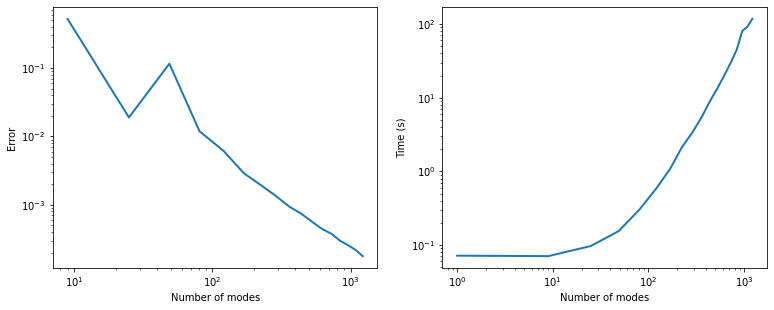

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=[12.8, 4.8])
ni = np.arange(1, N_max + 1, 2) ** 2

ax[0].loglog(ni[1:], np.abs(np.diff(RT[0])), linewidth=2)
ax[0].set_xlabel('Number of modes')
ax[0].set_ylabel('Error')

ax[1].loglog(ni, tt, linewidth=2)
ax[1].set_xlabel('Number of modes')
ax[1].set_ylabel('Time (s)')
plt.show()

## FFT

The scaling of the FFT can be obtained through the `Layer.fft_convergence` method which returns a tuple of the time taken for each computation and the maximum difference in the norms of the FFT matrices compared to the previous computation.

#### Parameters
- `max_res`: The maximum resolution to compute the FFT for.
- `n_res`: The number of steps in the resolution from the minimum i.e. $2N-1$ to `max_res`.
- `N`: Defines the minimum resolution and truncates the central $2N-1$ orders from the FFT solution.
- `period`: The period of the lattice. Increasing the period will also increase size of grid if resolution is constant.
- `n_iter=3`: The number of computations over which the time is averaged.

In [4]:
m_res = 1e4
n = 25
N = 11
(err, T) = phc.fft_convergence(m_res, n, N, p)

Sim 1: res = (420.16, 420.16)
Time = 0.097, diff = 6.37489
Sim 2: res = (819.32, 819.32)
Time = 0.174, diff = 0.38888
Sim 3: res = (1218.48, 1218.48)
Time = 0.411, diff = 0.12686
Sim 4: res = (1617.64, 1617.64)
Time = 0.85, diff = 0.08134
Sim 5: res = (2016.8000000000002, 2016.8000000000002)
Time = 1.376, diff = 0.04078
Sim 6: res = (2415.96, 2415.96)
Time = 2.231, diff = 0.02462
Sim 7: res = (2815.1200000000003, 2815.1200000000003)
Time = 1.07, diff = 0.08873
Sim 8: res = (3214.28, 3214.28)
Time = 3.484, diff = 0.03219
Sim 9: res = (3613.44, 3613.44)
Time = 4.931, diff = 0.02107
Sim 10: res = (4012.6000000000004, 4012.6000000000004)
Time = 5.001, diff = 0.02142
Sim 11: res = (4411.76, 4411.76)
Time = 7.203, diff = 0.0149
Sim 12: res = (4810.92, 4810.92)
Time = 7.787, diff = 0.01207
Sim 13: res = (5210.08, 5210.08)
Time = 8.493, diff = 0.04923
Sim 14: res = (5609.240000000001, 5609.240000000001)
Time = 4.851, diff = 0.01525
Sim 15: res = (6008.400000000001, 6008.400000000001)
Time = 11

Since the values are stored, the scaling and accuracy can be quickly visualized.

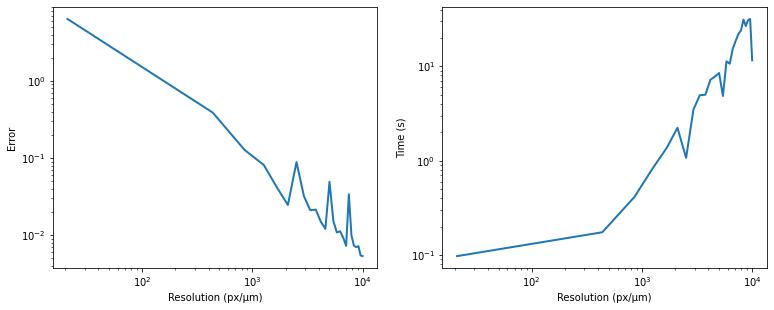

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=[12.8, 4.8])
ri = np.linspace(2 * N - 1, m_res, n)

ax[0].loglog(ri, err, linewidth=2)
ax[0].set_xlabel('Resolution (px/μm)')
ax[0].set_ylabel('Error')

ax[1].loglog(ri, T, linewidth=2)
ax[1].set_xlabel('Resolution (px/μm)')
ax[1].set_ylabel('Time (s)')
plt.show()